<a href="https://colab.research.google.com/github/Kalkidan-Negaro/PDAN8412_Part-1_Kalkidan_Negaro/blob/main/BlogAuthorship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Kaggle API & Import Libraries

In this step, we install the Kaggle API to allow downloading datasets directly from Kaggle.  




In [2]:
# Install Kaggle API
!pip install kaggle --quiet

# Import libraries
import os
import pandas as pd
from pyspark.sql import SparkSession


## 2. Set Up Kaggle API Credentials

Before we can download datasets from Kaggle, we need to configure the Kaggle API with our credentials.


In [3]:
# Create the Kaggle configuration directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Define Kaggle API credentials
kaggle_json = """{
  "username": "kalkidannegaro",
  "key": "56273c9b0c9282ea43bc43da48c44ac9"
}"""

# Save the credentials to the appropriate file
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    f.write(kaggle_json)

# Set file permissions for security
!chmod 600 ~/.kaggle/kaggle.json


## 3. Start Spark Session

Create a Spark session to allow working with Spark DataFrames and perform distributed data processing.


In [4]:
# Initialize a Spark session
spark = SparkSession.builder.appName("BlogAuthorshipEDA").getOrCreate()
print("✅ Spark session started")


✅ Spark session started


## 4. Download and Load Dataset

Download the Blog Authorship Corpus from Kaggle, check the file exists, and load it into a Pandas DataFrame for initial inspection.


In [5]:
# Define the dataset path
dataset_path = "/content/blog_data/blogtext.csv"

# Download the dataset using Kaggle API
!kaggle datasets download -d rtatman/blog-authorship-corpus -p /content/blog_data --unzip

# Check if the CSV file exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"CSV file not found at {dataset_path}")

# Load the CSV file into a Pandas DataFrame
blog_df = pd.read_csv(dataset_path)

# Display the first few rows of the dataframe
blog_df.head()


Dataset URL: https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus
License(s): other
 90% 260M/290M [00:00<00:00, 613MB/s] 
100% 290M/290M [00:00<00:00, 612MB/s]


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


## 5. Load CSV into Spark DataFrame

Read the CSV file into a Spark DataFrame, infer column types, and display the schema and first few rows.


In [7]:
# Specify the path to the CSV file
csv_file = "/content/blog_data/blogtext.csv"

# Read the CSV file into a Spark DataFrame
spark_df = spark.read.csv(csv_file, header=True, inferSchema=True)
# Print the schema of the DataFrame to check column names and data types
spark_df.printSchema()
spark_df.show(5, truncate=100)


root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- topic: string (nullable = true)
 |-- sign: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)

+-------+------+---+-----------------+--------+------------+----------------------------------------------------------------------------------------------------+
|     id|gender|age|            topic|    sign|        date|                                                                                                text|
+-------+------+---+-----------------+--------+------------+----------------------------------------------------------------------------------------------------+
|2059027|  male| 15|          Student|     Leo| 14,May,2004|           Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait until...|
|2059027|  male| 15|          Student|     Leo| 13,May,2004|           These are the team me

## 6. Exploratory Data Analysis

Explore the dataset by checking the schema, missing values, post counts per author, text length distribution, and a sample word cloud.


root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- topic: string (nullable = true)
 |-- sign: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- text_length: integer (nullable = true)

+-------+------+---+-----------------+--------+------------+----------------------------------------------------------------------------------------------------+-----------+
|     id|gender|age|            topic|    sign|        date|                                                                                                text|text_length|
+-------+------+---+-----------------+--------+------------+----------------------------------------------------------------------------------------------------+-----------+
|2059027|  male| 15|          Student|     Leo| 14,May,2004|           Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait until...|        157|


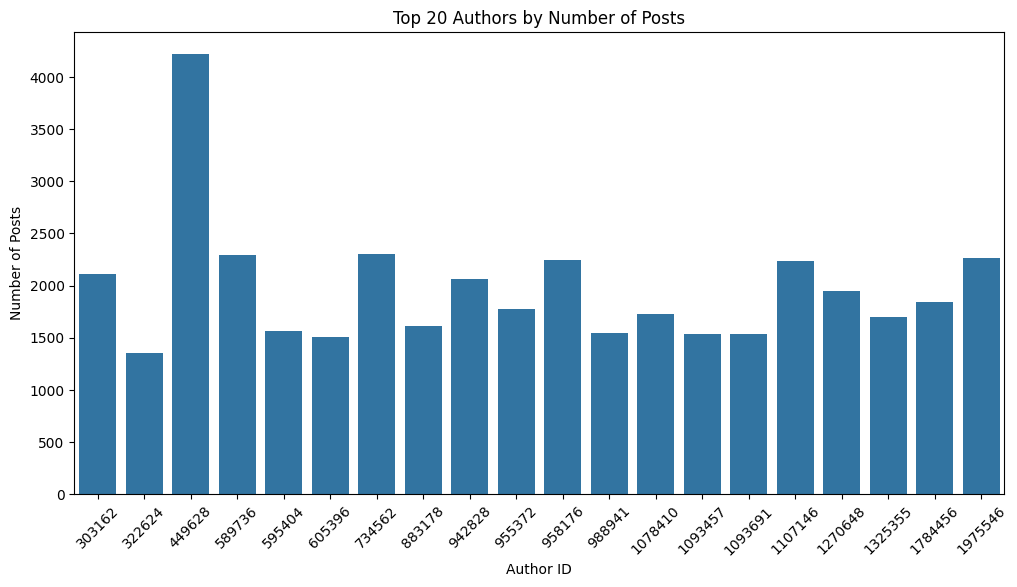

+-------+-----------------+
|summary|      text_length|
+-------+-----------------+
|  count|           681284|
|   mean|1120.809920679188|
| stddev|2328.577991302056|
|    min|                4|
|    max|           790123|
+-------+-----------------+



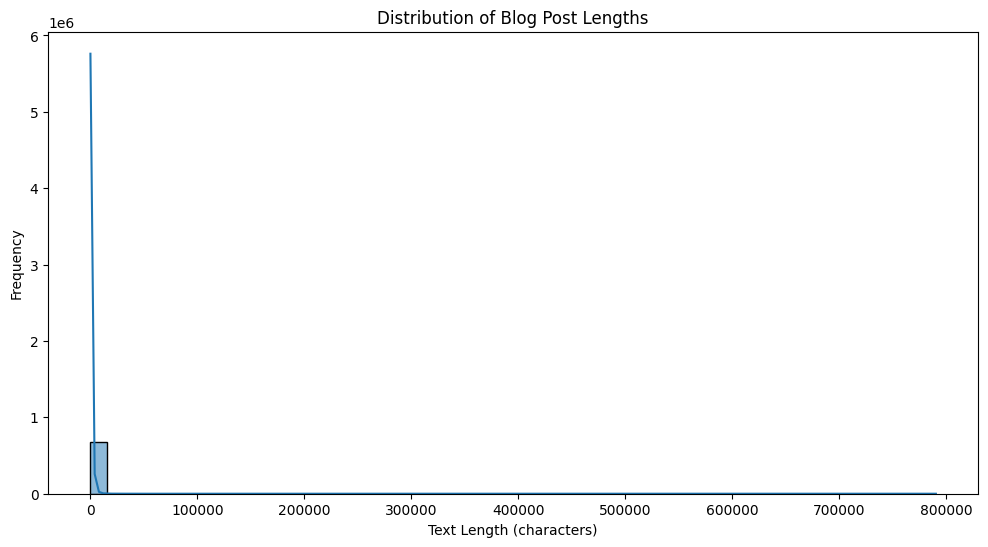

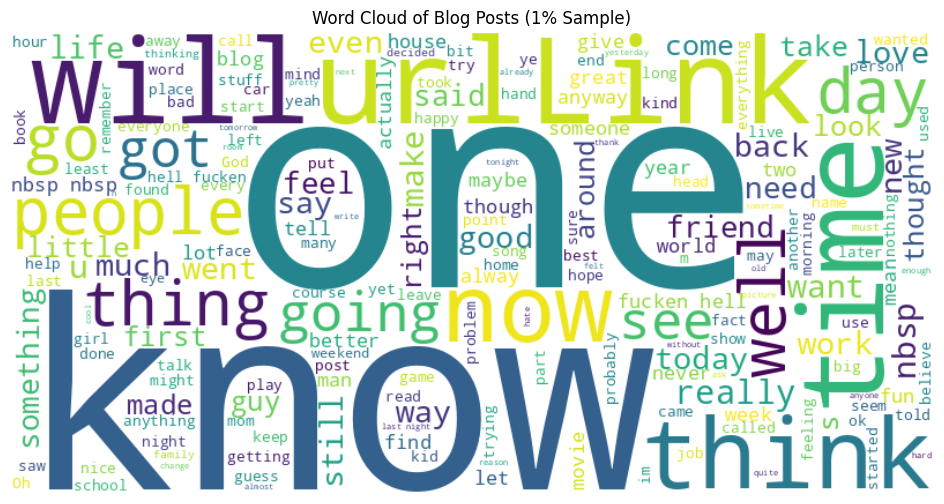

In [11]:

# EDA
from pyspark.sql.functions import col, length, isnan, when, count
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Check schema and first rows
spark_df.printSchema()
spark_df.show(5, truncate=100)

# Check for null or missing values
missing_values = spark_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in spark_df.columns])
missing_values.show()

# Number of posts per author (id)
author_counts = spark_df.groupBy("id").count().orderBy(col("count").desc())
author_counts.show(10)

# Plot top 20 authors by number of posts
top_authors_pd = author_counts.limit(20).toPandas()
plt.figure(figsize=(12,6))
sns.barplot(x="id", y="count", data=top_authors_pd)
plt.xticks(rotation=45)
plt.title("Top 20 Authors by Number of Posts")
plt.xlabel("Author ID")
plt.ylabel("Number of Posts")
plt.show()

# Text length analysis
spark_df = spark_df.withColumn("text_length", length(col("text")))
spark_df.select("text_length").describe().show()

# Histogram of text lengths
text_lengths_pd = spark_df.select("text_length").toPandas() #(Hunter, 2007; Waskom, 2021)
plt.figure(figsize=(12,6))
sns.histplot(text_lengths_pd["text_length"], bins=50, kde=True)
plt.title("Distribution of Blog Post Lengths")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

# Word cloud ( avoid memory crash)
sample_texts = spark_df.select("text").sample(fraction=0.01, seed=42).rdd.flatMap(lambda x: x).collect() #(Mueller, 2017)
all_text = " ".join(sample_texts)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Blog Posts (1% Sample)")
plt.show()


## 7. Preprocessing for LSTM

Prepare text data for LSTM by sampling the dataset, encoding authors, tokenizing and padding text, and splitting into training and test sets.


In [13]:
#  Preprocessing for LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Take a 10k random sample from Spark DataFrame to avoid memory issues
sample_spark_df = spark_df.sample(fraction=0.02, seed=42)
pdf = sample_spark_df.select("text", "id").toPandas()
print(f"Sampled dataset size: {pdf.shape}")

# Encode author IDs
label_encoder = LabelEncoder()
pdf['author_label'] = label_encoder.fit_transform(pdf['id'])

# Tokenize text
max_words = 20000  # vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(pdf['text'])
sequences = tokenizer.texts_to_sequences(pdf['text'])

# Pad sequences
max_len = 200  # max sequence length
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = tf.keras.utils.to_categorical(pdf['author_label'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Sampled dataset size: (13788, 2)
Training samples: 11030, Testing samples: 2758


## 8. LSTM Model

Build and train an LSTM with embedding, LSTM, dropout, and dense layers for multi-class author classification.


In [14]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = max_words
embedding_dim = 128
num_classes = y.shape[1]

# Define the Sequential model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 841ms/step - accuracy: 0.0030 - loss: 8.5881 - val_accuracy: 0.0091 - val_loss: 8.4783
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 831ms/step - accuracy: 0.0069 - loss: 8.1625 - val_accuracy: 0.0091 - val_loss: 8.5945
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 83s 844ms/step - accuracy: 0.0057 - loss: 8.0902 - val_accuracy: 0.0091 - val_loss: 8.7224
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 852ms/step - accuracy: 0.0066 - loss: 7.9753 - val_accuracy: 0.0091 - val_loss: 8.7665
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 66s 846ms/step - accuracy: 0.0055 - loss: 7.8362 - val_accuracy: 0.0082 - val_loss: 8.8943


## 9. Model Evaluation

Evaluate the LSTM with a classification report and confusion matrix for the top 20 authors.


87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step
Classification Report:
              precision    recall  f1-score   support

        5114       0.00      0.00      0.00         3
        8173       0.00      0.00      0.00         3
        8349       0.00      0.00      0.00         2
        9289       0.00      0.00      0.00         1
        9470       0.00      0.00      0.00         1
       15365       0.00      0.00      0.00         2
       17944       0.00      0.00      0.00         1
       21828       0.00      0.00      0.00         1
       24336       0.00      0.00      0.00         4
       28417       0.00      0.00      0.00         1
       49663       0.00      0.00      0.00         3
       64145       0.00      0.00      0.00         1
       72355       0.00      0.00      0.00         1
       75671       0.00      0.00      0.00         2
       76211       0.00      0.00      0.00         1
       78196       0.00      0.00      0.00         1
       91374    

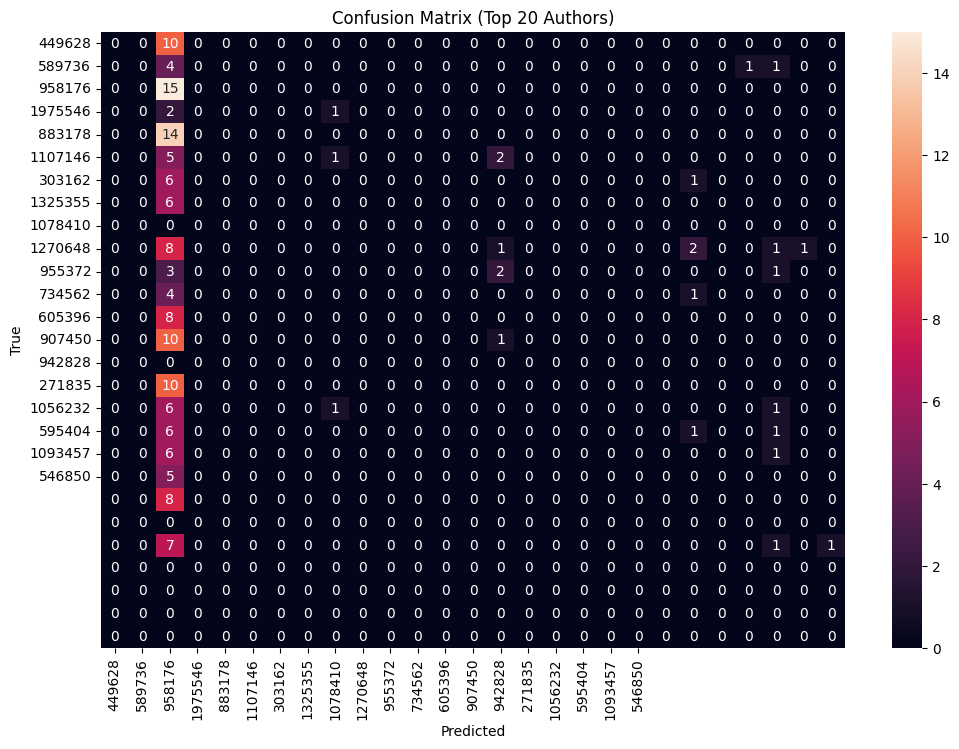

In [17]:
# Model Evaluation
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
y_pred_probs = model.predict(X_test) #(Abadi et al., 2016)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get classes present in y_true
classes_in_test = np.unique(y_true)

# Convert label indices to author IDs (strings)
target_names = label_encoder.inverse_transform(classes_in_test).astype(str)

# Classification report (only for classes present in test)
print("Classification Report:") #(Pedregosa et al., 2011)
print(classification_report(
    y_true,
    y_pred,
    labels=classes_in_test,
    target_names=target_names,
    zero_division=0
))

# Confusion matrix (top 20 authors by post count in sample)
top_20_authors = pdf['id'].value_counts().head(20).index
top_20_labels = label_encoder.transform(top_20_authors)
mask = np.isin(y_true, top_20_labels)
cm = confusion_matrix(y_true[mask], y_pred[mask])

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=top_20_authors, yticklabels=top_20_authors)
plt.title("Confusion Matrix (Top 20 Authors)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 10. Reference List

Kaggle, 2025. Blog Authorship Corpus Dataset. [Dataset] Available at: https://www.kaggle.com/rtatman/blog-authorship-corpus
 [Accessed 2 October 2025].



Abadi, M., Agarwal, A., Barham, P., Brevdo, E., Chen, Z., Citro, C., Corrado, G.S., Davis, A., Dean, J., Devin, M., et al., 2016. TensorFlow: Large-scale machine learning on heterogeneous systems. [Software] Available at: https://www.tensorflow.org/
 [Accessed 2 October 2025].

 Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., et al., 2011. Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, pp.2825–2830.

 Hunter, J.D., 2007. Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), pp.90–95.

 Waskom, M.L., 2021. Seaborn: Statistical Data Visualization. Journal of Open Source Software, 6(60), p.3021.

